In [1]:
%matplotlib inline

In [2]:
from thetis import *
from firedrake_adjoint import *

In [3]:
import adolc

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOkadaOptions
from adapt_utils.unsteady.solver import AdaptiveProblem
from adapt_utils.unsteady.solver_adjoint import AdaptiveDiscreteAdjointProblem

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Computing the gradient of timeseries misfit w.r.t. Okada parameters

In this work we compute gradients of quantities of interest of the form

$$
    J(\mathbf u,\eta;\mathbf m)
    =\int_0^T\int_\Omega\sum_{g\in\mathcal G}\mathbb1_g(\eta-\eta_g)^2\;\mathrm dx\;\mathrm dt,
$$

where $\mathcal G$ is a set of gauges and associated with gauge $g\in\mathcal G$ are free surface measurements $\eta_g$ and a neighbourhood indicator function $\mathbb1_g$.
Here $\mathbf m$ is a vector of control parameters which define the tsunami source.

In this notebook, $\mathbf m$ contains parameters associated with an Okada function representation on an array of subfaults.
That is, the initial surface elevation $\eta_0$ is given by

$$
    \eta_0(\mathbf x)=\mathrm{Okada}(\mathbf m),
$$

where $\mathrm{Okada}$ denotes the Okada model. This is then passed to a shallow water forward propagation model as an initial condition:

$$
    \mathbf u(\mathbf x,0)=\boldsymbol0,\quad
    \eta(\mathbf x,0)=\eta_0(\mathbf x).
$$

We can use `pyadjoint` to compute the gradient of $J$ with respect to this initial surface, or to solve the discrete adjoint problem.
In particular, it can give us the adjoint solution at the initial time, $\eta^*(\mathbf x,0)$, for a given $\eta_0$.

We can use `pyadolc` to differentiate through the Okada model, giving

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m},
$$

for some choice of control parameters, $\widetilde{\mathrm m}$.

Let $\Pi$ be a linear interpolation operator from the Okada grid to the mesh used in the tsunami propagation.
Then the action of the gradient on $\widetilde{\mathrm m}$ is given by

$$
    \frac{\mathrm dJ}{\mathrm d\mathrm m}\:\widetilde{\mathrm m}=
    \int_\Omega\eta^*(\mathbf x,0)\:\Pi\left(
        \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m}
    \right)\;\mathrm dx.
$$

### Initialisation

Set parameters and create a `TohokuOkadaOptions` object to hold them

In [6]:
kwargs = {
    'level': 0,
    'synthetic': True,
    'plot_pvd': False,
    'save_timeseries': True,
    'family': 'dg-cg',
    'stabilisation': None,
}
plotting_kwargs = {
    'cmap': 'coolwarm',
    'levels': 50,
}
nonlinear = False

In [7]:
op = TohokuOkadaOptions(**kwargs)

### Get timeseries data

We use a 'synthetic' approach whereby 'the truth' is given by timeseries extracted from a model run with some Okada parameters.

In [8]:
with stop_annotating():
    swp = AdaptiveProblem(op, nonlinear=nonlinear)
    swp.solve_forward()  # NOTE: pyadolc annotation is also off
    for gauge in op.gauges:
        op.gauges[gauge]["data"] = op.gauges[gauge]["timeseries"]

#### TODO: Setup strong residual for Crank-Nicolson
 0  FORWARD SOLVE mesh  1/ 1  time     0.00
 0  FORWARD SOLVE mesh  1/ 1  time    60.00
 0  FORWARD SOLVE mesh  1/ 1  time   120.00
 0  FORWARD SOLVE mesh  1/ 1  time   180.00
 0  FORWARD SOLVE mesh  1/ 1  time   240.00
 0  FORWARD SOLVE mesh  1/ 1  time   300.00
 0  FORWARD SOLVE mesh  1/ 1  time   360.00
 0  FORWARD SOLVE mesh  1/ 1  time   420.00
 0  FORWARD SOLVE mesh  1/ 1  time   480.00
 0  FORWARD SOLVE mesh  1/ 1  time   540.00
 0  FORWARD SOLVE mesh  1/ 1  time   600.00
 0  FORWARD SOLVE mesh  1/ 1  time   660.00
 0  FORWARD SOLVE mesh  1/ 1  time   720.00
 0  FORWARD SOLVE mesh  1/ 1  time   780.00
 0  FORWARD SOLVE mesh  1/ 1  time   840.00
 0  FORWARD SOLVE mesh  1/ 1  time   900.00
 0  FORWARD SOLVE mesh  1/ 1  time   960.00
 0  FORWARD SOLVE mesh  1/ 1  time  1020.00
 0  FORWARD SOLVE mesh  1/ 1  time  1080.00
 0  FORWARD SOLVE mesh  1/ 1  time  1140.00
 0  FORWARD SOLVE mesh  1/ 1  time  1200.00
 0  FORWARD SOLVE mesh  

### Solve forward and adjoint tsunami model

Now that we have timeseries data, we can run the forward model with some initial guess parameter choices and compare the resulting timeseries against them.
In this case the initial guess is given by adding some Normal random noise to the original parameters.

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.
During the forward run, `pyadjoint` also annotates its own tape, allowing us to later solve the adjoint problem.

In [9]:
class DiscreteAdjointTsunamiProblem(AdaptiveDiscreteAdjointProblem):
    """The subclass exists to pass the QoI as required."""
    def quantity_of_interest(self):
        return self.op.J

In [11]:
kwargs['control_parameters'] = op.control_parameters
for control in op.active_controls:
    kwargs['control_parameters'][control] += np.random.normal(size=np.shape(op.control_parameters[control]))
op_opt = TohokuOkadaOptions(**kwargs)
for gauge in op_opt.gauges:
    op_opt.gauges[gauge]["data"] = op.gauges[gauge]["data"]

In [12]:
tape_tag = 0
swp = DiscreteAdjointTsunamiProblem(op_opt, nonlinear=nonlinear)
swp.set_initial_condition(annotate_source=True, tag=tape_tag)

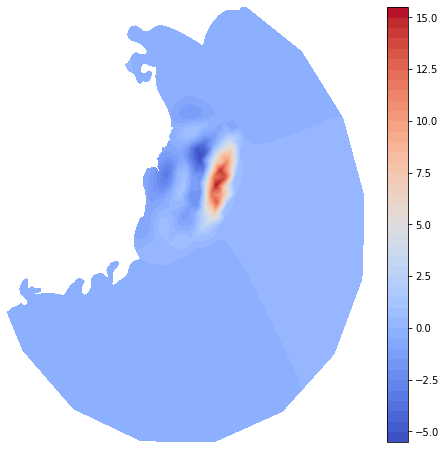

In [13]:
fig, axes = plt.subplots(figsize=(8, 8))
eta = swp.fwd_solutions[0].split()[1].copy(deepcopy=True)
fig.colorbar(tricontourf(eta, axes=axes, **plotting_kwargs), ax=axes);
axes.axis(False);

Store the initial condition so that it may be interpreted as a control by `pyadjoint` and then solve forward.

In [14]:
source_control = Control(swp.fwd_solutions[0])
swp.setup_solver_forward(0)
swp.solve_forward_step(0)
print("QoI: {:.4e}".format(op_opt.J))

#### TODO: Setup strong residual for Crank-Nicolson
 0  FORWARD SOLVE mesh  1/ 1  time     0.00
 0  FORWARD SOLVE mesh  1/ 1  time    60.00
 0  FORWARD SOLVE mesh  1/ 1  time   120.00
 0  FORWARD SOLVE mesh  1/ 1  time   180.00
 0  FORWARD SOLVE mesh  1/ 1  time   240.00
 0  FORWARD SOLVE mesh  1/ 1  time   300.00
 0  FORWARD SOLVE mesh  1/ 1  time   360.00
 0  FORWARD SOLVE mesh  1/ 1  time   420.00
 0  FORWARD SOLVE mesh  1/ 1  time   480.00
 0  FORWARD SOLVE mesh  1/ 1  time   540.00
 0  FORWARD SOLVE mesh  1/ 1  time   600.00
 0  FORWARD SOLVE mesh  1/ 1  time   660.00
 0  FORWARD SOLVE mesh  1/ 1  time   720.00
 0  FORWARD SOLVE mesh  1/ 1  time   780.00
 0  FORWARD SOLVE mesh  1/ 1  time   840.00
 0  FORWARD SOLVE mesh  1/ 1  time   900.00
 0  FORWARD SOLVE mesh  1/ 1  time   960.00
 0  FORWARD SOLVE mesh  1/ 1  time  1020.00
 0  FORWARD SOLVE mesh  1/ 1  time  1080.00
 0  FORWARD SOLVE mesh  1/ 1  time  1140.00
 0  FORWARD SOLVE mesh  1/ 1  time  1200.00
 0  FORWARD SOLVE mesh  

QoI: 2.9783e+04


Compute the gradient and extract the adjoint solution at time $t=0$.

In [16]:
swp.compute_gradient(source_control)
swp.get_solve_blocks()
swp.extract_adjoint_solution(0)
u_star, eta_star = swp.adj_solutions[0].split()

 0   ADJOINT EXTRACT mesh  1/ 1  time     0.00


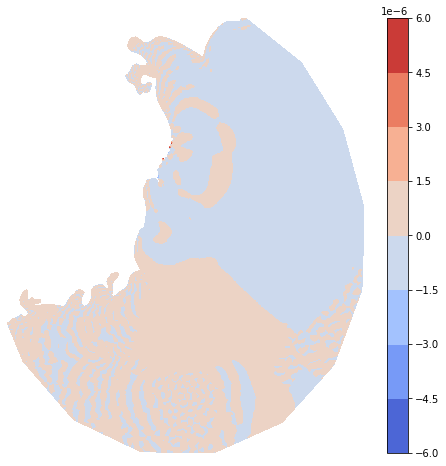

In [17]:
fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(tricontourf(eta_star, axes=axes, cmap='coolwarm'), ax=axes);
axes.axis(False);

### Differentate the source model

In [20]:
op_opt.get_seed_matrices()
F, dFdX = adolc.fov_forward(tape_tag, op_opt.active_input_vector, op_opt.seed_matrices)
print(F.shape)
print(dFdX.shape)

(10201,)
(10201, 4)


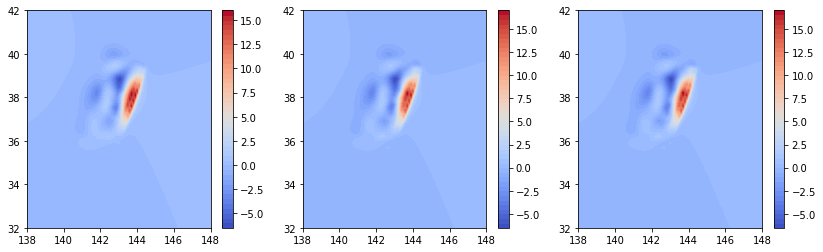

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
N = op.N
fig.colorbar(axes[0].contourf(X, Y, op.fault.dtopo.dZ.reshape(N, N), **plotting_kwargs), ax=axes[0]);
fig.colorbar(axes[1].contourf(X, Y, op_opt.fault.dtopo.dZ.reshape(N, N), **plotting_kwargs), ax=axes[1]);
fig.colorbar(axes[2].contourf(X, Y, F.reshape(N, N), **plotting_kwargs), ax=axes[2]);

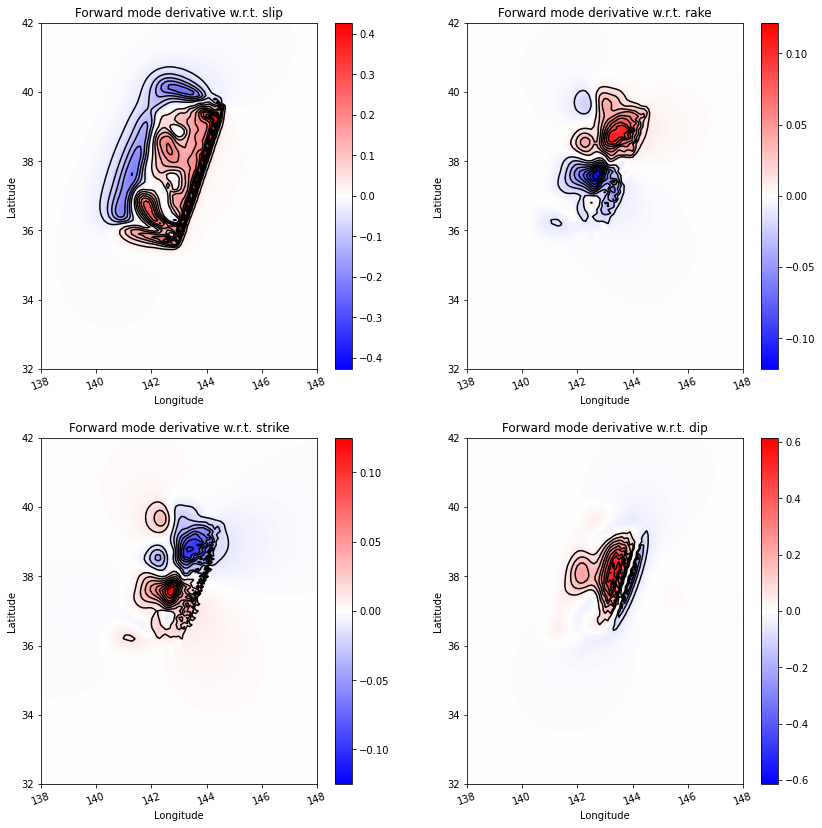

In [22]:
m = int(np.sqrt(len(op_opt.active_controls)))
fig, axes = plt.subplots(ncols=m, nrows=m, figsize=(7*m, 7*m))

for i, control in enumerate(op_opt.active_controls):
    ax = axes[i // m, i % m]
    op_opt.fault.dtopo.dZ = dFdX[:, i].reshape(1, op_opt.N, op_opt.N)
    op_opt.fault.dtopo.plot_dZ_colors(t=1.0, axes=ax);
    ax.set_xlabel('Longitude');
    ax.set_ylabel('Latitude');
    ax.set_title('Forward mode derivative w.r.t. {:s}'.format(control));
    ax.images[-1].colorbar.set_label('');

### Establish interpolation operator from Okada grid to mesh

Creating the Okada mesh is easy: just use `Firedrake`'s utility meshes.
Note that the first two arguments to `SquareMesh` are the number of *cells* in each direction, whereas `N` is the number of *vertices*.

In [146]:
N = op.N
okada_mesh = SquareMesh(N-1, N-1, 10, 10)
okada_mesh.coordinates.dat.data[:] += [138, 32]

In [147]:
# fig, axes = plt.subplots(figsize=(12, 12))
# triplot(okada_mesh, axes=axes);
# axes.set_xlabel("Longitude [degrees]");
# axes.set_ylabel("Latitude [degrees]");

Create source and target spaces and a projector between them

In [148]:
P1_okada = FunctionSpace(okada_mesh, "CG", 1)
source = Function(P1_okada)
P1_lonlat = FunctionSpace(op.lonlat_mesh, "CG", 1)
target = Function(P1_lonlat)
proj = firedrake.projection.SupermeshProjector(source, target)

In [149]:
X = np.linspace(0, N, N)
x_locations = []
y_locations = []
for i, coord in enumerate(okada_mesh.coordinates.dat.data):
    x_locations.append(int((coord[0] - 138)*(N-1)/10))
    y_locations.append(int((coord[1] - 32)*(N-1)/10))

In [154]:
def field_from_array(arr):
    for k in range(N*N):
        source.dat.data[k] = arr[y_locations[k], x_locations[k]]

In [158]:
dZ = op.fault.dtopo.dZ.reshape(N, N)

In [159]:
field_from_array(dZ)
proj.project();

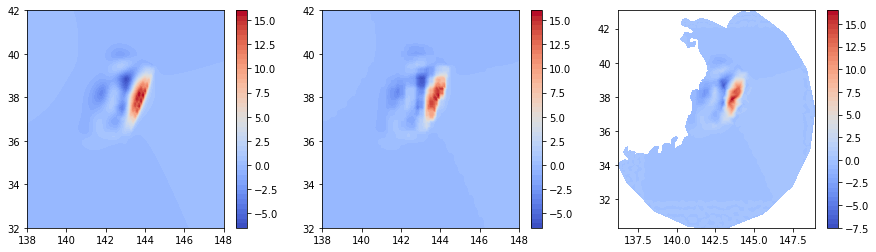

In [162]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

fig.colorbar(axes[0].contourf(op.fault.dtopo.X, op.fault.dtopo.Y, dZ, **plotting_kwargs), ax=axes[0]);
fig.colorbar(tricontourf(source, axes=axes[1], **plotting_kwargs), ax=axes[1]);
fig.colorbar(tricontourf(target, axes=axes[2], **plotting_kwargs), ax=axes[2]);

# TODO: Why the distortion from 1 to 2? Could use scipy instead if needed
# TODO: apply chain rule